# Training of Convolutional Network for Figures Recognition

The aim of this notebook is to train a Convolutional Net using tensorflow and keras with the aim of using it to predict the figures in the cards.

### $\bullet$ Importing libraries and utilitary functions

In [1]:
# Import python libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%load_ext autoreload
%autoreload 2
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import utilitary functions and module defining the Unet model.
from scripts.data_generator import DataGenerator
from scripts.model import convolutional_network
from scripts.plots import plot_history

### $\bullet$ Setting different paths

In [2]:
# Variable defining where the datasets are saved.
mnist_path   = os.path.join(os.getcwd(), "Dataset", "Mnist"  , "mnist.npz")
figures_path = os.path.join(os.getcwd(), "Dataset", "Figures", "figures.npz")

# Variable defining where models will be stored.
model_save_path = os.path.join(os.getcwd(), "Models", "Convolutional Network")

### $\bullet$ Load images from the dataset

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

def get_train_val_test_data(mnist_path, figures_path, batch_size, val_split = 0.3, resolution = (28, 28)):
    # Load data from Mnist.
    (mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = tf.keras.datasets.mnist.load_data(path = mnist_path)
    
    # Load figures and figures labels.
    figures_loaded_file = np.load(figures_path)
    figures_images = figures_loaded_file['figures']
    figures_labels  = figures_loaded_file['labels']
    
    # Train-Validation Split of Mnist ensuring label balance.
    train_idx, val_idx = next(StratifiedShuffleSplit(n_splits = 1, test_size = val_split).split(mnist_train_images, mnist_train_labels))
    mnist_val_images = mnist_train_images[val_idx]
    mnist_val_labels = mnist_train_labels[val_idx]
    mnist_train_images = mnist_train_images[train_idx]
    mnist_train_labels = mnist_train_labels[train_idx]
    
    print(f'Training set contains {len(mnist_train_images)} images.')
    print(f'Validation set contains {len(mnist_val_images)} images.')
    print(f'Test set contains {len(mnist_test_images)} images.')
    
    # Creating Train, Validation and Test generators.
    train_generator = DataGenerator(mnist_train_images, mnist_train_labels, figures_images, figures_labels, 
                                    resolution, batch_size, augment_mnist_data = True, augment_figure_data = True)
    val_generator   = DataGenerator(mnist_val_images  , mnist_val_labels  , figures_images, figures_labels, 
                                    resolution, batch_size, augment_mnist_data = False, augment_figure_data = False)
    test_generator  = DataGenerator(mnist_test_images , mnist_test_labels , figures_images, figures_labels, 
                                    resolution, batch_size, augment_mnist_data = False, augment_figure_data = False)
    
    return train_generator, val_generator, test_generator

batch_size = 130
train_generator, val_generator, test_generator = get_train_val_test_data(mnist_path, figures_path, batch_size = batch_size)

Training set contains 42000 images.
Validation set contains 18000 images.
Test set contains 10000 images.


### $\bullet$ Training Convolutional Model using Data Augmentation

In [4]:
# Setting up parameters used for training
number_epochs = 150
early_stopping = EarlyStopping(patience = 25, verbose = 1)
model_checkpoint = ModelCheckpoint(filepath = model_save_path, save_weights_only = False, monitor = 'val_accuracy', save_best_only = True)

# Building model.
model = convolutional_network(show_summary = True)

# Compiling model.
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 128)         401536    
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 13)          1

In [5]:
# Training
history = model.fit(train_generator, validation_data = val_generator, epochs = number_epochs, callbacks = [early_stopping, model_checkpoint])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 379 steps, validate for 162 steps
Epoch 1/150
378/379 [============================>.] - ETA: 0s - loss: 1.1563 - accuracy: 0.6172WARNING:tensorflow:From C:\Anaconda3\envs\image_proc\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\andre\Desktop\Cours Image Processing\Project\Models\Convolutional Network\assets
379/379 [==============================] - 20s 52ms/step - loss: 1.1548 - accuracy: 0.6176 - val_loss: 0.1953 - val_accuracy: 0.9490
Epoch 2/150
379/379 [==============================] - 19s 50ms/step - loss: 0.5460 - accuracy: 0.8284 - val_loss: 0.1225 - val_accuracy: 0.9643
Epoch 3/150
379/379 [================

379/379 [==============================] - 20s 53ms/step - loss: 0.1117 - accuracy: 0.9673 - val_loss: 0.0381 - val_accuracy: 0.9880
Epoch 30/150
379/379 [==============================] - 20s 54ms/step - loss: 0.1114 - accuracy: 0.9673 - val_loss: 0.0376 - val_accuracy: 0.9882
Epoch 31/150
379/379 [==============================] - 21s 55ms/step - loss: 0.1089 - accuracy: 0.9689 - val_loss: 0.0386 - val_accuracy: 0.9881
Epoch 32/150
379/379 [==============================] - 22s 57ms/step - loss: 0.1110 - accuracy: 0.9677 - val_loss: 0.0408 - val_accuracy: 0.9877
Epoch 33/150
379/379 [==============================] - 23s 60ms/step - loss: 0.1048 - accuracy: 0.9687 - val_loss: 0.0346 - val_accuracy: 0.9891
Epoch 34/150
379/379 [==============================] - 20s 53ms/step - loss: 0.1048 - accuracy: 0.9704 - val_loss: 0.0384 - val_accuracy: 0.9879
Epoch 35/150
379/379 [==============================] - 20s 52ms/step - loss: 0.1027 - accuracy: 0.9695 - val_loss: 0.0387 - val_accuracy

379/379 [==============================] - 17s 45ms/step - loss: 0.0761 - accuracy: 0.9775 - val_loss: 0.0329 - val_accuracy: 0.9903
Epoch 76/150
379/379 [==============================] - 18s 47ms/step - loss: 0.0745 - accuracy: 0.9783 - val_loss: 0.0351 - val_accuracy: 0.9892
Epoch 77/150
379/379 [==============================] - 18s 47ms/step - loss: 0.0728 - accuracy: 0.9777 - val_loss: 0.0357 - val_accuracy: 0.9898
Epoch 78/150
379/379 [==============================] - 18s 46ms/step - loss: 0.0723 - accuracy: 0.9784 - val_loss: 0.0333 - val_accuracy: 0.9901
Epoch 79/150
379/379 [==============================] - 19s 50ms/step - loss: 0.0767 - accuracy: 0.9780 - val_loss: 0.0329 - val_accuracy: 0.9904
Epoch 80/150
379/379 [==============================] - 22s 57ms/step - loss: 0.0731 - accuracy: 0.9785 - val_loss: 0.0313 - val_accuracy: 0.9906
Epoch 81/150
379/379 [==============================] - 22s 57ms/step - loss: 0.0737 - accuracy: 0.9784 - val_loss: 0.0345 - val_accuracy

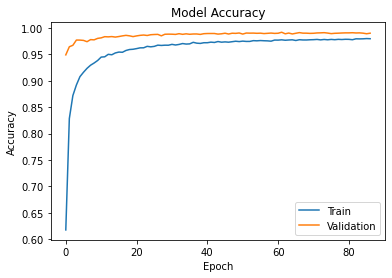

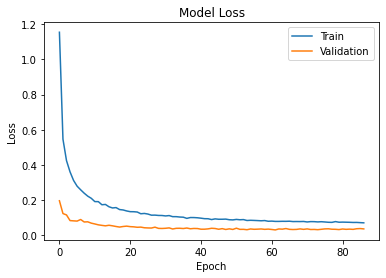

In [6]:
plot_history(history)

### $\bullet$ Evaluating Model on Test Set.

89/89 [==============================] - 1s 12ms/step - loss: 0.0227 - accuracy: 0.9915


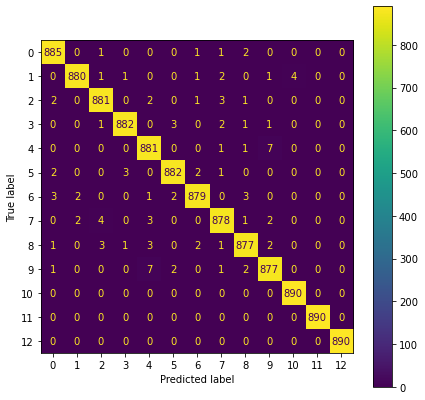

In [7]:
# Load best model saved by ModelCheckpoint
model = tf.keras.models.load_model(model_save_path)

# Evaluate best model
model.evaluate(test_generator)

predictions = model.predict(test_generator)
predictions = np.argmax(predictions.squeeze(), axis = 1)

labels = []
for idx in range(len(test_generator)):
    _, labels_batch = test_generator[idx]
    labels.extend(labels_batch)

matrix = confusion_matrix(labels, predictions)
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
ConfusionMatrixDisplay(matrix, display_labels = sorted(np.unique(labels))).plot(ax = ax)

### $\bullet$ Visualize the Result of Data Augmentation.

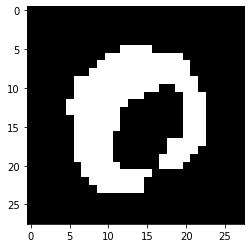

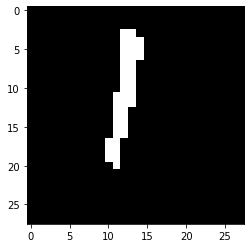

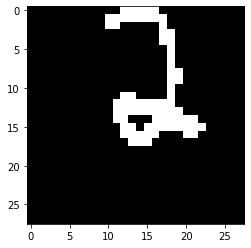

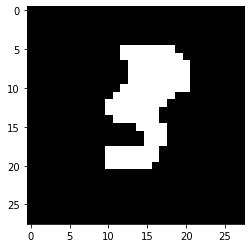

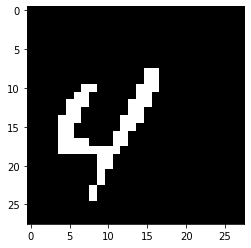

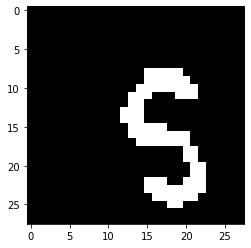

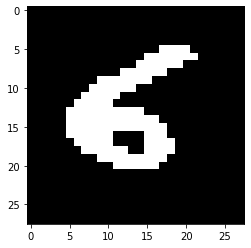

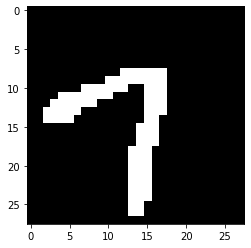

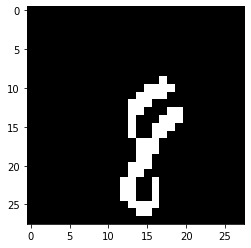

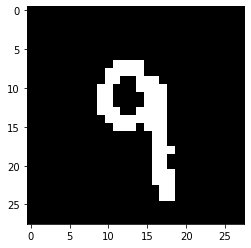

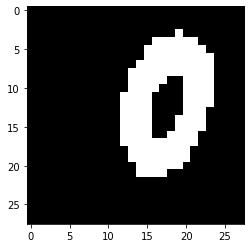

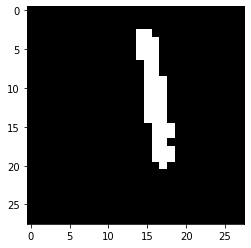

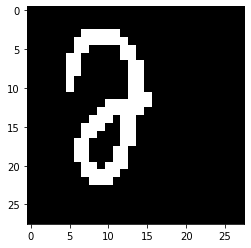

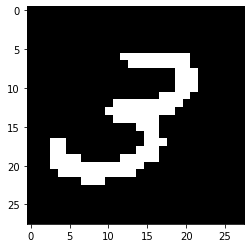

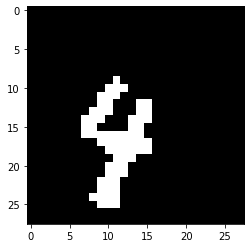

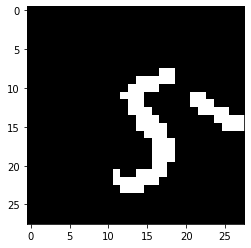

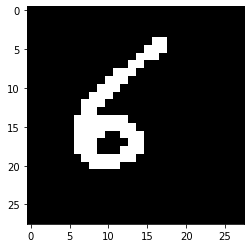

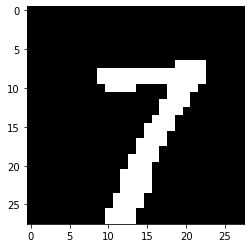

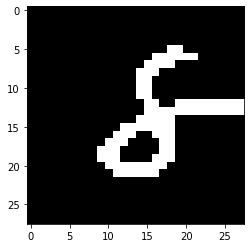

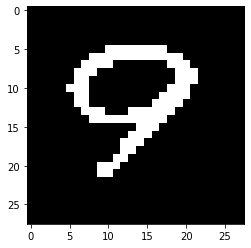

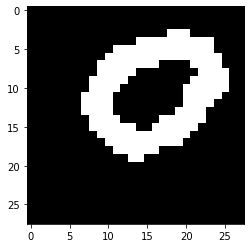

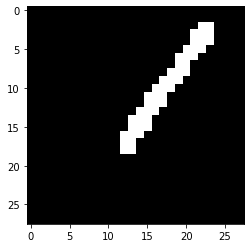

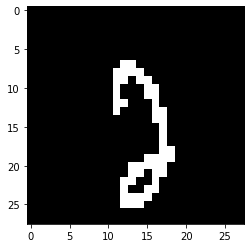

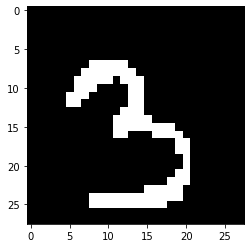

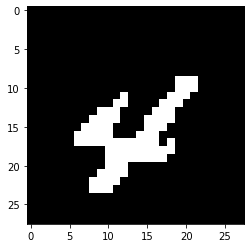

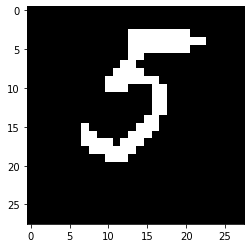

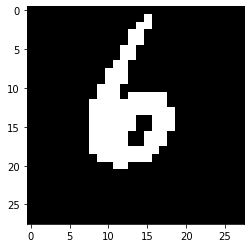

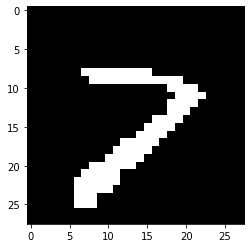

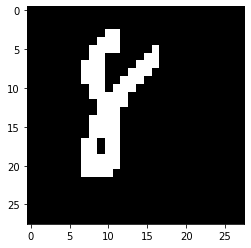

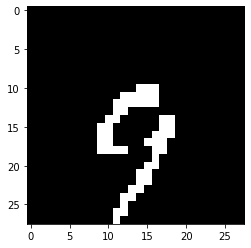

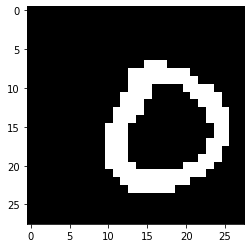

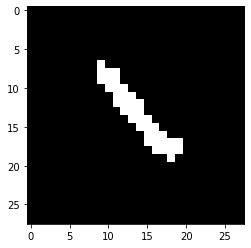

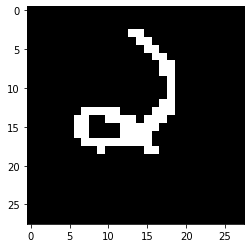

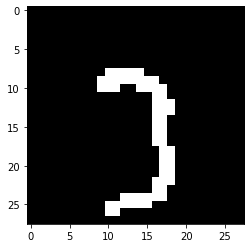

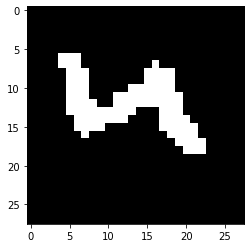

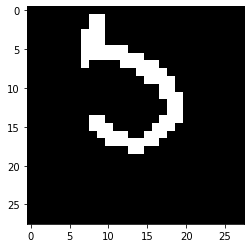

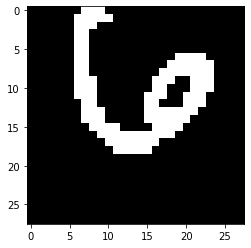

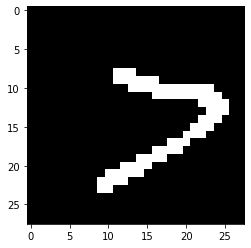

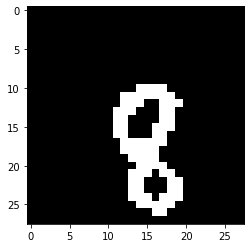

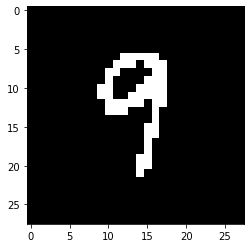

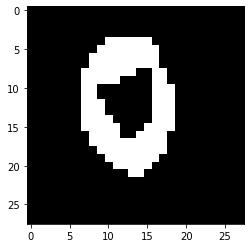

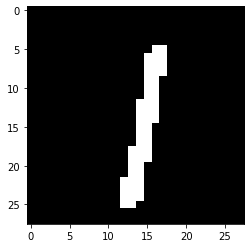

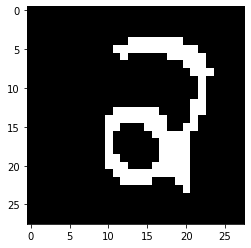

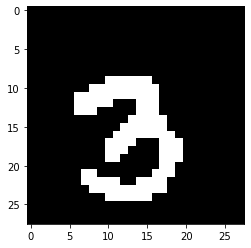

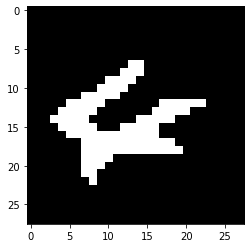

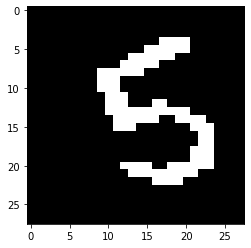

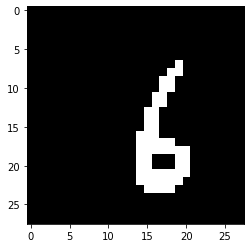

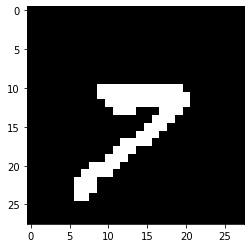

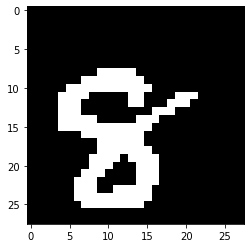

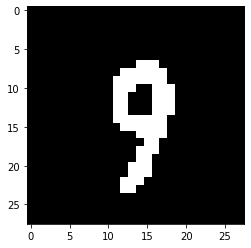

In [8]:
for i in range(50):
    new_image = train_generator[i // batch_size][0][i % batch_size]
    
    plt.imshow(new_image, cmap = 'gray')
    plt.show()